In [14]:
%pip install scikit-learn

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [15]:
import pandas as pd
import re,os,sys
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import string
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\selam\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\selam\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\selam\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [16]:
rating_df=pd.read_csv("../data/rating.csv")
domain_locations_df = pd.read_csv("../data/domains_location.csv")
traffic_data_df = pd.read_csv("../data/traffic.csv")

# Drop duplicates
rating_df.drop_duplicates(inplace=True)
domain_locations_df.drop_duplicates(inplace=True)
traffic_data_df.drop_duplicates(inplace=True)

# Drop unnecessary columns
if 'source_id' in rating_df.columns:
    rating_df.drop(columns=['source_id'], inplace=True)

if 'url_to_image' in rating_df.columns:
    rating_df.drop(columns=['url_to_image'], inplace=True)

# Drop rows with missing values
rating_df = rating_df.dropna(axis=0)
domain_locations_df = domain_locations_df.dropna(axis=0)

# rating_df['domain'] = rating_df['url'].apply(get_domain)

merge_df=pd.merge(rating_df, domain_locations_df ,left_on='source_name', right_on ='SourceCommonName' ,how ='left')
merge_df=pd.merge(merge_df, traffic_data_df , left_on ='source_name' ,right_on='Domain' ,how ='left')

Number of events: 10
News sites reporting events earliest:
 source_name
Android Central                 2023-10-01 20:00:46.000000
Al Jazeera English              2023-10-01 20:22:17.000000
Deadline                        2023-10-01 23:35:34.000000
BBC News                        2023-10-02 00:04:05.000000
Business Insider                2023-10-02 00:10:25.000000
RT                              2023-10-02 01:32:33.000000
Forbes                          2023-10-02 02:03:15.000000
The Indian Express              2023-10-02 02:04:23.000000
International Business Times    2023-10-02 02:45:30.000000
Time                            2023-10-02 05:00:00.000000
GlobeNewswire                   2023-10-02 05:30:00.000000
The Times of India              2023-10-02 06:42:03.000000
Phys.Org                        2023-10-02 07:30:39.000000
Globalsecurity.org              2023-10-02 08:07:51.000000
Marketscreener.com              2023-10-02 08:16:05.000000
NPR                             2023-10-02 

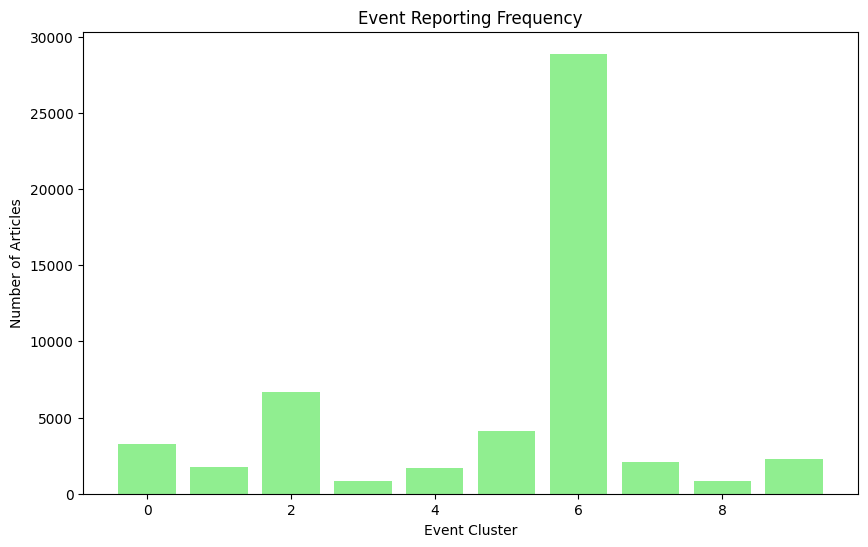

In [17]:
stop_words = set(stopwords.words('english'))
ps = PorterStemmer()

def preprocess_text(text):
    text = text.lower()

    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)

    tokens = word_tokenize(text)
    # Remove stop words and apply stemming
    filtered_tokens = [ps.stem(word) for word in tokens if word not in stop_words]
    # Join the filtered tokens back into text
    preprocessed_text = ' '.join(filtered_tokens)
    return preprocessed_text

merge_df['preprocessed_content'] = merge_df['content'].apply(preprocess_text)

vectorizer = TfidfVectorizer(stop_words='english')
tfidf_matrix = vectorizer.fit_transform(merge_df['preprocessed_content'])

#  Clustering
num_clusters = 10  # Choose an appropriate number of clusters
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
kmeans.fit(tfidf_matrix)


merge_df['cluster'] = kmeans.labels_

# Count the number of events covered in the data
num_events = merge_df['cluster'].nunique()
print("Number of events:", num_events)

# Determine which news sites report events the earliest
earliest_reporting = merge_df.groupby('source_name')['published_at'].min()
earliest_reporting = earliest_reporting.sort_values()
print("News sites reporting events earliest:\n", earliest_reporting)

event_counts = merge_df['cluster'].value_counts()
print("Event reporting frequency:\n", event_counts)

# Plotting
plt.figure(figsize=(10, 6))
plt.bar(event_counts.index, event_counts.values, color='lightgreen')  
plt.xlabel('Event Cluster')
plt.ylabel('Number of Articles')
plt.title('Event Reporting Frequency')
plt.show()


In [18]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.metrics.pairwise import cosine_similarity
from scipy.sparse import csr_matrix
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import string

# Read data
rating_df = pd.read_csv("../data/rating.csv")
domain_locations_df = pd.read_csv("../data/domains_location.csv")
traffic_data_df = pd.read_csv("../data/traffic.csv")

# Drop duplicates
rating_df.drop_duplicates(inplace=True)
domain_locations_df.drop_duplicates(inplace=True)
traffic_data_df.drop_duplicates(inplace=True)

# Drop unnecessary columns
rating_df.drop(columns=['source_id', 'url_to_image'], inplace=True)

# Drop rows with missing values
rating_df.dropna(axis=0, inplace=True)
domain_locations_df.dropna(axis=0, inplace=True)

# Merge dataframes
merge_df = pd.merge(rating_df, domain_locations_df, left_on='source_name', right_on='SourceCommonName', how='left')
merge_df = pd.merge(merge_df, traffic_data_df, left_on='source_name', right_on='Domain', how='left')

# Preprocess text data
def preprocess_text(text):
    tokens = word_tokenize(text)
    tokens = [token.lower() for token in tokens if token.isalnum()]
    stop_words = set(stopwords.words('english'))
    tokens = [token for token in tokens if token not in stop_words]
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(token) for token in tokens]
    preprocessed_text = ' '.join(tokens)
    return preprocessed_text

merge_df['processed_content'] = merge_df['content'].apply(preprocess_text)

# Sample the data
sample_size = 1000  # Adjust the sample size as needed
merge_df = merge_df.sample(n=sample_size, random_state=42)

# Vectorize the text data
vectorizer = CountVectorizer(max_df=0.95, min_df=2, stop_words='english')
X = vectorizer.fit_transform(merge_df['processed_content'])

X_sparse = csr_matrix(X)
cosine_sim_matrix = cosine_similarity(X_sparse)
similarity_threshold = 0.5

# Fit LDA model
num_topics = 10  # Adjust the number of topics as needed
lda_model = LatentDirichletAllocation(n_components=num_topics, random_state=42)
lda_model.fit(X)

# Assign topics to articles
merge_df['topic'] = lda_model.transform(X).argmax(axis=1)

# Apply event detection to each article in the sampled subset
related_articles_list = []
for article_index in range(len(merge_df)):
    related_articles = set()
    for i, similarity_score in enumerate(cosine_sim_matrix[article_index]):
        if similarity_score > similarity_threshold:
            related_articles.add(i)
    related_articles_list.append(related_articles)

merge_df['related_articles'] = related_articles_list

# Explore the detected events
for event_id, event_articles in enumerate(merge_df['related_articles']):
    print(f"Event {event_id}:")
    for article_index in event_articles:
        if article_index < len(merge_df):  # Check if the index is within bounds
            article = merge_df.iloc[article_index][['title', 'content']]
            print(article)
    print()



Event 0:
title      usher gears up for 2024 super bowl halftime sh...
content    Los Angeles- While Usher gears up for his 2024...
Name: 2830, dtype: object

Event 1:
title      India vs Australia: Suryakumar Yadav to lead I...
content    Suryakumar Yadav will lead the Indian cricket ...
Name: 41738, dtype: object

Event 2:
title      UNHCR warns worsening conditions and challenge...
content    UNHCR - United Nations High Commissioner for R...
Name: 33426, dtype: object

Event 3:
title      FundCanna Partners with National Cannabis Indu...
content    SAN DIEGO, Nov. 14, 2023 (GLOBE NEWSWIRE) -- F...
Name: 29879, dtype: object

Event 4:
title      Should you buy LIC stock post 50% YoY fall in ...
content    Notwithstanding a 50% year-on-year decline in ...
Name: 27667, dtype: object

Event 5:
title      KeyCorp Trims Corteva (NYSE:CTVA) Target Price...
content    Corteva (NYSE:CTVA – Free Report) had its targ...
Name: 23802, dtype: object
title      AVITA Medical’s (RCEL) Overweight Rat

In [19]:
# Create a set to store unique sets of related articles
unique_events = set()

# Iterate over each row in the DataFrame
for related_articles in merge_df['related_articles']:
    unique_events.add(tuple(sorted(related_articles)))  # Convert the set to a tuple for immutability and sort for consistency

# Count the number of unique events
num_events = len(unique_events)

print(f"Number of events covered in the data: {num_events}")


Number of events covered in the data: 951


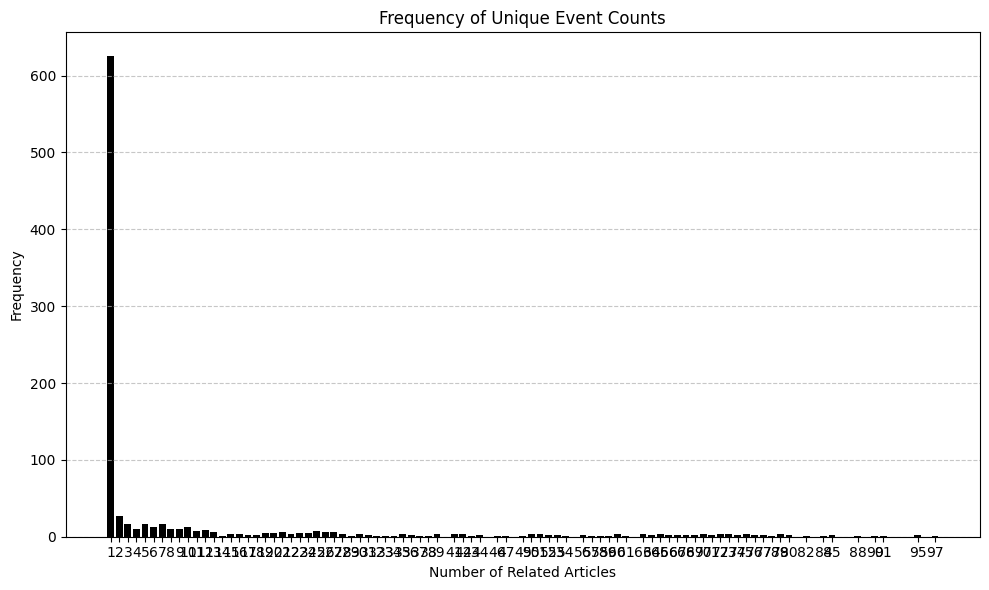

In [26]:
import matplotlib.pyplot as plt

# Count the frequency of each unique event count
event_counts = [len(event) for event in unique_events]
event_count_freq = {count: event_counts.count(count) for count in set(event_counts)}

# Plot the frequency of unique event counts
plt.figure(figsize=(10, 6))
plt.bar(event_count_freq.keys(), event_count_freq.values(), color='black')  # Changing color to sky blue
plt.title('Frequency of Unique Event Counts')
plt.xlabel('Number of Related Articles')
plt.ylabel('Frequency')
plt.xticks(list(event_count_freq.keys()))
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


In [21]:
# Count occurrences of each set of related articles (events)
event_counts = merge_df['related_articles'].value_counts()

# Find the events with the highest reporting
highest_reporting_events = event_counts[event_counts == event_counts.max()]

# Display the events with the highest reporting
print("Events with the highest reporting:")
for event, count in highest_reporting_events.items():
    print(f"Event: {event}, Count: {count}")


Events with the highest reporting:
Event: {704, 584, 42, 749, 722, 664, 859}, Count: 5
Event: {161, 931, 137, 906, 84}, Count: 5


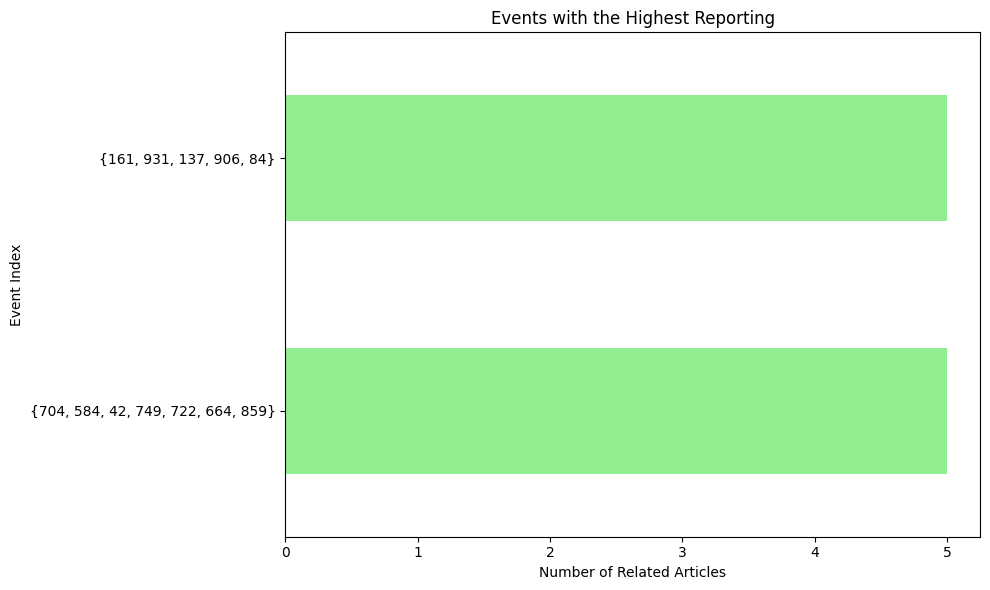

In [27]:
import matplotlib.pyplot as plt

# Plot the events with the highest reporting
plt.figure(figsize=(10, 6))
highest_reporting_events.plot(kind='barh', color='lightgreen')  # Changing plot type to horizontal bar plot and color to light green
plt.title('Events with the Highest Reporting')
plt.xlabel('Number of Related Articles')
plt.ylabel('Event Index')
plt.tight_layout()
plt.show()


In [23]:
import pandas as pd

# Create a list of unique news sites
news_sites = merge_df['source_name'].unique()

# Initialize a dictionary to store the binary matrix for each event
binary_matrices = {}

# Iterate over each event and construct the binary matrix
for idx, event_articles in enumerate(merge_df['related_articles']):
    # Initialize a binary vector for the current event
    binary_vector = [0] * len(news_sites)
    # Mark the news sites that reported on the event
    reported_sites = merge_df[merge_df.index.isin(event_articles)]['source_name'].unique()
    for site in reported_sites:
        if site in news_sites:
            binary_vector[list(news_sites).index(site)] = 1
    # Add the binary vector to the dictionary
    binary_matrices[idx] = binary_vector

# Convert the dictionary to a DataFrame
binary_matrix = pd.DataFrame.from_dict(binary_matrices, orient='index', columns=news_sites)

# Calculate the correlation matrix
correlation_matrix = binary_matrix.corr()

# Display the correlation matrix
print("Correlation between news sites reporting events:")
print(correlation_matrix)


Correlation between news sites reporting events:
                              The Times of India  The Indian Express  \
The Times of India                      1.000000                 NaN   
The Indian Express                           NaN                 NaN   
Globalsecurity.org                     -0.006045                 NaN   
GlobeNewswire                          -0.004606                 NaN   
ETF Daily News                         -0.001736                 NaN   
Al Jazeera English                     -0.002456                 NaN   
ABC News                                0.214709                 NaN   
RT                                     -0.008784                 NaN   
International Business Times                 NaN                 NaN   
Time                                         NaN                 NaN   
Deadline                                     NaN                 NaN   
Forbes                                 -0.001736                 NaN   
BBC News       

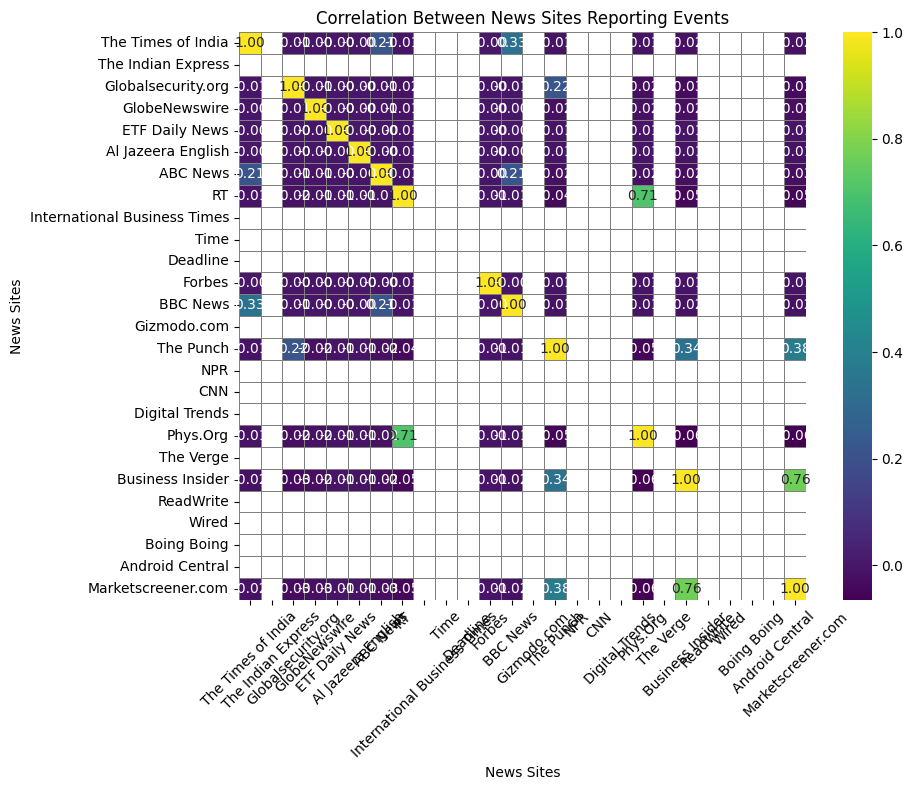

In [29]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create a heatmap of the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='viridis', fmt=".2f", square=True, 
            linewidths=0.5, linecolor='gray')  # Change the colormap to 'viridis', add gray lines between cells
plt.title('Correlation Between News Sites Reporting Events')
plt.xlabel('News Sites')
plt.ylabel('News Sites')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()
